In [1]:
from conf import databases, url, data_dir
from file_utils import create_folder
from dnn_helper import *
from rpeak_nn import *

import numpy
import random
import time

import lasagne
from matplotlib import pyplot as plt
import matplotlib as mpl

Using gpu device 0: GeForce GTX 1050 Ti (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)
/home/jdu/anac3.5/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
fs = 128
fs_target = 360
min_bpm = 10
max_bpm = 350
min_gap = fs*60/min_bpm
max_gap = fs*60/max_bpm

train_perc = 99
test_perc = 100 - train_perc

params = {
    'fs_target': 360,
    'segment_size': 5000, 
    'segment_step': 2500, 
    'normalize_steps': True,
    'correct_peaks': True,
    'left_border': 50, # samples
    'right_border': 50, # samples
    'min_gap': min_gap,
    'max_gap': max_gap
}

In [3]:
architecture = [
    (0.5, [
            (3, 8, 'rectify', 'same'),
            (15, 64, 'rectify', 'same'),
            (45, 64, 'rectify', 'same'),
            (89, 32, 'rectify', 'same'),
            (149, 16, 'rectify', 'same'),
            (199, 16, 'rectify', 'same'),
            (299, 16, 'rectify', 'same'),
    ]),
    (0.5, [
            (3, 8, rectify, 'same'),
            (9, 64, rectify, 'same'),
            (19, 64, rectify, 'same'),
            (39, 64, rectify, 'same'),
    ]),
    (0.5, [
            (3, 8, rectify, 'same'),
            (5, 32, rectify, 'same'),
            (9, 32, rectify, 'same'),
            (15, 32, rectify, 'same'),
            (19, 32, rectify, 'same'),
    ]),
    (0.5, [
            (3, 8, rectify, 'same'),
            (5, 32, rectify, 'same'),
            (15, 64, rectify, 'same'),
    ]),
    (0.5, [
            (5, 16, rectify, 'same'),
            (15, 16, rectify, 'same'),
            (19, 16, rectify, 'same'),
    ]),
    (0.5, [
            (3, 8, rectify, 'same'),
            (9, 16, rectify, 'same'),
            (15, 16, rectify, 'same'),
    ])
]

nn = NN(architecture, dim=1, params=params)

Model shape:
  Layer A:
    a1: (None, 8, 5000)
    a2: (None, 64, 5000)
    a3: (None, 64, 5000)
    a4: (None, 32, 5000)
    a5: (None, 16, 5000)
    a6: (None, 16, 5000)
    a7: (None, 16, 5000)
   al: (None, 216, 5000)
  Layer B:
    b1: (None, 8, 5000)
    b2: (None, 64, 5000)
    b3: (None, 64, 5000)
    b4: (None, 64, 5000)
   bl: (None, 136, 5000)
  Layer C:
    c1: (None, 8, 5000)
    c2: (None, 32, 5000)
    c3: (None, 32, 5000)
    c4: (None, 32, 5000)
    c5: (None, 32, 5000)
   cl: (None, 136, 5000)
  Layer D:
    d1: (None, 8, 5000)
    d2: (None, 32, 5000)
    d3: (None, 64, 5000)
   dl: (None, 104, 5000)
  Later E:
    e1: (None, 16, 5000)
    e2: (None, 16, 5000)
    e3: (None, 16, 5000)
   el: (None, 48, 5000)
  Layer F:
    f1: (None, 8, 5000)
    f2: (None, 16, 5000)
    f3: (None, 16, 5000)
   fl: (None, 40, 5000)
  Layer G:
    g1: (None, 1, 5000)
   gl: (None, 1, 5000)


In [4]:
exs = shuffled_examples(databases, 360, 5000, 2500, True, True)
train_exs = exs[:int(len(exs)*train_perc/100)]
test_exs  = exs[int(len(exs)*train_perc/100):]
print('Number of examples: {} ({} samples)'.format(len(exs), len(exs)*5000))
print('          Training: {} ({} samples)'.format(len(train_exs), len(train_exs)*5000))
print('           Testing: {} ({} samples)'.format(len(test_exs), len(test_exs)*5000))

Number of examples: 12432 (62160000 samples)
          Training: 12307 (61535000 samples)
           Testing: 125 (625000 samples)


In [5]:
_, params = load_model('saved-models/170516-mit-sv-nsr-lt-sd/model-loss0.061288795094135894-epoch500.sav')
#print(params)
set_all_param_values(nn.model, params)
nn.init_funs(nn.model)

Evaluating..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

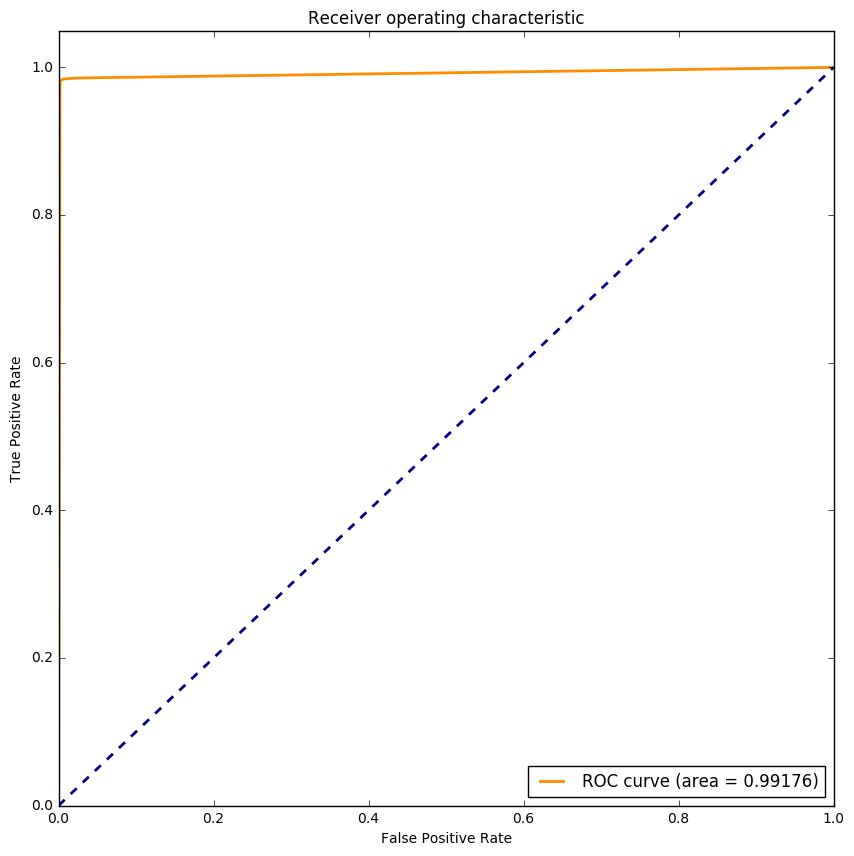

Samples:		60916800 samples
Beats:
  - 218180 labelized
  - 319954 detected
  - TP:  213861/218180
  - FP:  106093/0
  - TPR: 0.9802


In [8]:
nn.min_gap = min_gap
nn.max_gap = max_gap

eval_model(exs, nn.evaluate, nn.min_gap, nn.max_gap, nn.left_border, nn.right_border, *nn.params, exs=numpy.arange(len(exs)),
                       plot_examples=False, nb=None, nearest_fpr=0.005, threshold=0.999, eval_margin=10)

[    76     77     78 ..., 649735 649991 649992]


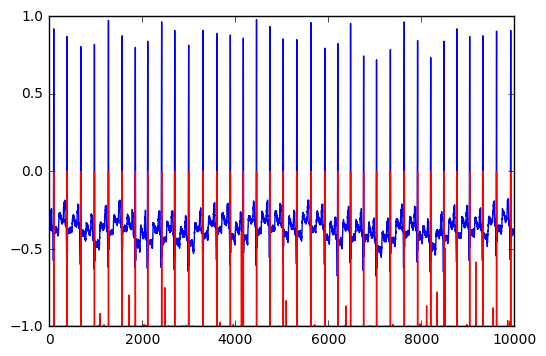

In [18]:
from preproc import *


def unstepize(y, segment_size, segment_step):
    N = len(y)
    cut = int(segment_step/2)
    
    res = None
    for i, e in enumerate(y):
        if i == 0:
            res = e[:cut+segment_step]
        elif i == N-1:
            res = numpy.concatenate((res, e[cut:]), axis=0)
        else:
            res = numpy.concatenate((res, e[cut:cut+segment_step]), axis=0)
    
    assert res.shape[0] == 2*(segment_step+cut)+(N-2)*segment_step
    return res

def compute_signal(x, nn, segment_size, segment_step, normalize_steps):
    def sigstepize(x, segment_size, segment_step, normalize_steps):
        assert x.shape[0] >= segment_size
        X = []
        for i in range(0, len(x)+1-segment_size, segment_step):
            if normalize_steps:
                xx = numpy.reshape(normalize(x[i:i+segment_size]), (segment_size, 1))
            else:
                xx = numpy.reshape(x[i:i+segment_size], (segment_size, 1))
            X.append(xx)
        assert len(X) == int(x.shape[0]/segment_step)-1
        return X
    
    Y = []
    for segment in sigstepize(x, segment_size, segment_step, normalize_steps):
        res = nn.evaluate(numpy.reshape(segment, (1, 1, segment_size)))
        res = res[0][0]
        Y.append(res)
        
    YY = unstepize(Y, segment_size, segment_step)
    return YY
        


f = 'data/mitdb/100'
sig, fields = wfdb.srdsamp(f)
fs = fields['fs']
ann = wfdb.rdann(f, 'atr')

x = sig[:, 0]
Y = compute_signal(x, nn, 5000, 2500, True)

lb=40000
ub=50000
print(numpy.where(Y>=0.97)[0])
plt.plot(x[lb:ub])
plt.plot(Y[lb:ub]-1, 'r')
plt.show()